## Figuring out how to develp the gap filling routine, baby step 1, fill one station, with data from 2 stations
Working off of : https://www.hatarilabs.com/ih-en/fill-missing-precipitation-data-with-artificial-intelligence-python-keras-tutorial

In [2]:
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container { width: 95%;} div#menubar-container { width: 85%; } div#maintoolbar-container { width: 99%; } </style> """))


#%matplotlib inline
%matplotlib notebook
import matplotlib 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy.polynomial.polynomial import polyfit
import seaborn as sns
import os
import datetime
import keras 
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler
import requests
import scipy
import tensorflow as tf

pd.set_option('display.max_rows', 200)    
np.set_printoptions(suppress=True)


In [3]:
url = "https://raw.githubusercontent.com/cshuler/ASPA-UH_Integrated_Modeling_Framework/master/ASPA-UH_Stream_REPO/workspace/All_consolodated_Q_m3ps.csv"
save_to = os.path.join(".", 'Data', "All_consolodated_Q_m3ps.csv")

r = requests.get(url, allow_redirects=True)
open(save_to, 'wb').write(r.content)

16200025

<IPython.core.display.Javascript object>


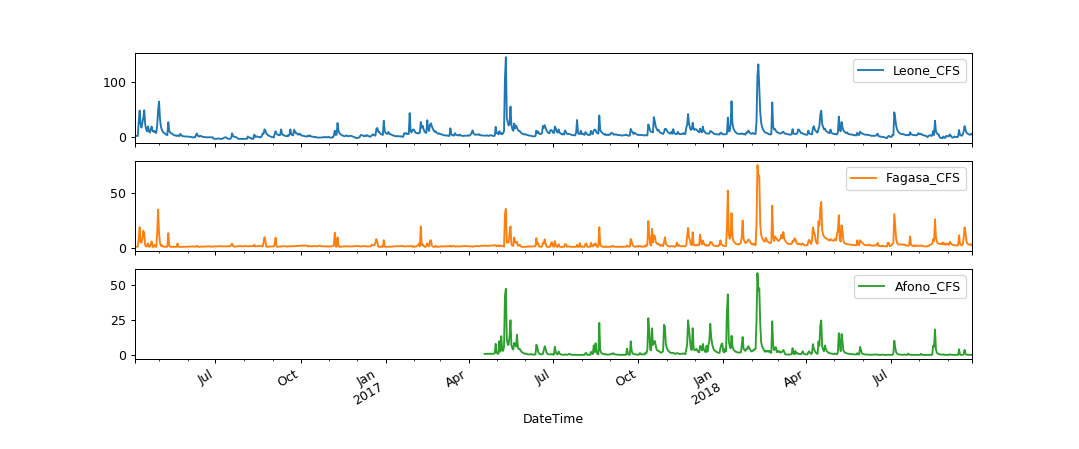

In [61]:
rawdata = pd.read_csv(save_to ,index_col=0,parse_dates=True)

dat = rawdata.resample('D').mean()     # subsample the 15 min data into daily values
dat = dat[8:]                          # this just to cut out some of the beginning days with no streamflows

data = pd.DataFrame(index=dat.index)
for column in dat:
    new_name = column.split("_")[0]+"_CFS"
    data[new_name] = dat[column]*35.314666212661 
    
# just using two training stations (Fagasa and Leone) and one fill station (Afono) here
data = data[['Leone_CFS', 'Fagasa_CFS', 'Afono_CFS']]

# clip data to remfe leone and fagasa end gaps
mindate = data['Leone_CFS'].dropna().index.min()
maxdate = data['Leone_CFS'].dropna().index.max()
data = data.loc[mindate:maxdate]
    
data.plot(subplots=True, figsize=(12, 5))
plt.legend(loc='best')

In [62]:
# we create a date column to extract the week number
data['date']=data.index    
data['week'] = data['date'].apply(lambda x: x.isocalendar()[1])
del data['date']                      #drop the date column because we dont need it

<IPython.core.display.Javascript object>


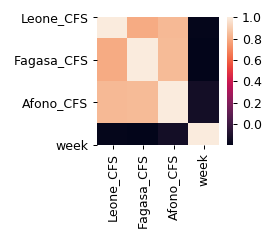

In [38]:
#creation of a correlation plot with seaborn
plt.figure(figsize=(3, 2.7))
corr = data.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt. tight_layout()

In [69]:
#Definition of training sets (Where there is existing data for all the staions)

Train_Start = data['Afono_CFS'].dropna().index.min()   # based on where afono gap stops
Train_End = data.index.max()

X_train = data.loc[Train_Start:Train_End,['Leone_CFS','Fagasa_CFS','week']].values  
y_train = data .loc[Train_Start:Train_End,'Afono_CFS'].values 

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

In [131]:
# Definte the neural netowrk parameters 

model = Sequential()

model.add(Dense(12, activation='linear', input_shape=(3,)))
model.add(Dense(80, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 12)                48        
_________________________________________________________________
dense_20 (Dense)             (None, 80)                1040      
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 81        
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________


In [132]:
# train the network
history = model.fit(X_train, y_train, epochs=200,verbose=0)

In [133]:
# run the training dataset back through the netowrk to show how well it predicts values over calibration data (comp vs obs) 
y_pred = model.predict(X_train)

<IPython.core.display.Javascript object>


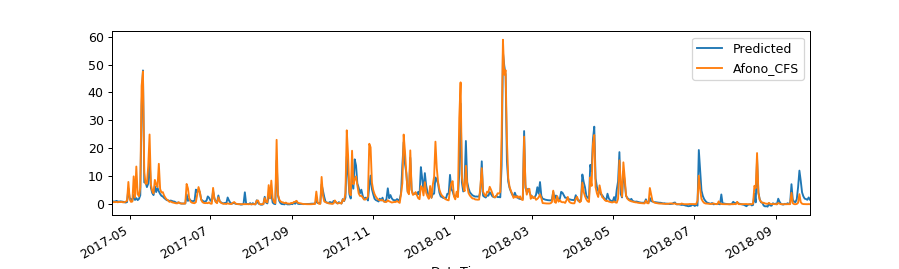

<IPython.core.display.Javascript object>


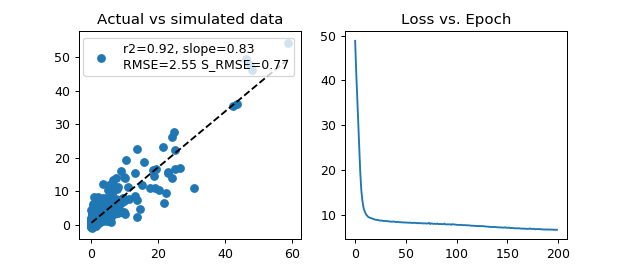

In [134]:
# view results of predictions on the calibration data (note this is not on validation data just calibration) 

x = np.squeeze(data['Afono_CFS'].loc[Train_Start:Train_End].values)
y = np.squeeze(y_pred)

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)                              # get stats on regression
mea = np.mean(np.abs(x-y))
rmse = np.sqrt(np.mean(np.abs(x-y)**2))                                     # couple more basic stats on the residuals, Mean absolute errir and root RMSE root mean squared error
Std_RMSE = rmse/((np.mean(x)+np.mean(y))/2)                                 # standardize the RMSE as a % of the mean

plt.figure(figsize=(10, 3))
plt.plot(data.loc[Train_Start:Train_End].index, y, label='Predicted')
data['Afono_CFS'].loc[Train_Start:Train_End].plot()
plt.legend(loc='best')

fig2, ax = plt.subplots(1, 2, figsize=(7, 3))
ax[0].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),  color = 'k', linestyle = "--")    # plot the linear regresion line 
ax[0].scatter(x, y, label="r2={0:1.2f}, slope={1:1.2f}\nRMSE={2:1.2f} S_RMSE={3:1.2f}".format(r_value, slope, rmse, Std_RMSE))   
ax[1].plot(history.history['loss'])
ax[0].set_title('Actual vs simulated data')
ax[1].set_title('Loss vs. Epoch')
ax[0].legend()

# Fill in missing values 

C:\Users\cshuler\Anaconda3\envs\tensorflow_env\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


<IPython.core.display.Javascript object>


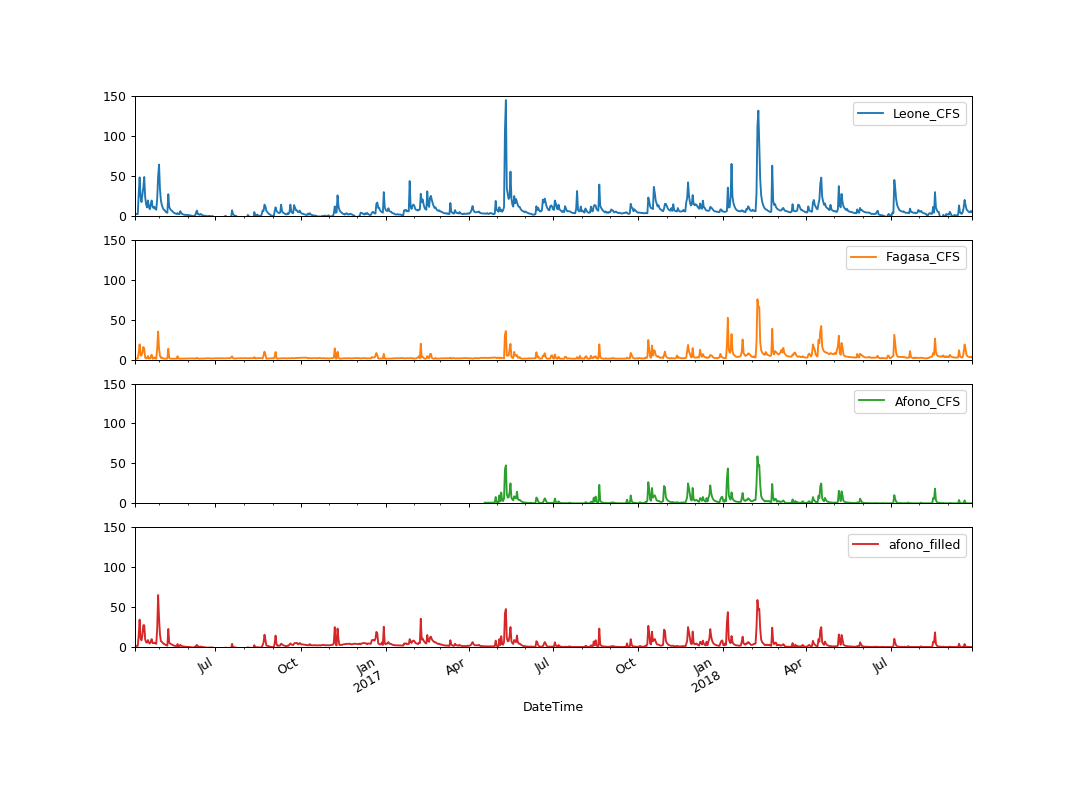

In [148]:
# Definition of filling datasets (Where there is a gap in the want to fill station)
Predict_Start = data.index.min()               # Start of the validatiaon data period, = end of training data 
Predict_End = data['Afono_CFS'].dropna().index.min()   # based on where afono gap stops                      

X_predict_known = data.loc[Predict_Start:Predict_End, ['Leone_CFS','Fagasa_CFS','week']].values 
scaler = StandardScaler().fit(X_predict_known)   # Define the scaler 
X_predict_known = scaler.transform(X_predict_known) # Scale the train set

# predict values for the gap period 
y_predict_unknown = model.predict(X_predict_known)
y_predict_unknown = y_predict_unknown.reshape([np.shape(y_predict_unknown)[0]]).tolist()

# create new data series with gaps filled in
data_filled = data.copy()
data_filled["afono_filled"] = data['Afono_CFS']
data_filled['afono_filled'].loc[Predict_Start:Predict_End] = y_predict_unknown
del data_filled['week'] 
data_filled.plot(subplots=True, figsize=(12, 9), ylim = (0,150))

plt.legend(loc='best')